
# Bit Flip Error Correction Code levraging non locality and paralelism of Neutral Atoms hardware

 This tutorial introduces the bit flip error correction code using the Bloqade framework. We'll explore how to build and simulate a quantum circuit that encodes logical qubits, simulates noise, and corrects errors using the bit flip code.

Quantum systems are inherently fragile. Even small interactions with the environment can lead to errors in the quantum state. Quantum error correction (QEC) is a critical component of building reliable quantum computers. The bit flip code provides a simple yet powerful method to protect information against `X` (bit flip) errors.

### Why Neutral Atom Hardware?

Neutral atom platforms have emerged as a powerful and scalable approach to quantum computing. Atoms are trapped in optical tweezers and manipulated using laser fields, providing key advantages:

- **High connectivity**: Any pair of atoms can be entangled through Rydberg interactions, enabling efficient multi-qubit operations.
- **Scalability**: Arrays of hundreds of atoms can be created in a compact footprint, with reconfigurable geometry.
- **Long coherence times**: Neutral atoms have low sensitivity to environmental noise, supporting longer quantum operations.
- **Native multi-qubit gates**: The Rydberg blockade mechanism allows for direct implementation of controlled operations.

The **Bloqade** framework is specifically designed to simulate and compile programs for neutral atom devices, making it a natural choice for prototyping quantum error correction codes on this architecture.

In [1]:

from bloqade import qasm2

from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
from bloqade.pyqrack import PyQrack
from collections import Counter
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

from src.helper import get_qasm_string

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold


/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


## Step 0: A bit of theory

Unlike classical bits, quantum bits (qubits) are prone to both bit flips (X errors), phase flips (Z errors), and combinations thereof (Y errors). Measurement destroys quantum information, so we must find ways to correct quantum errors *without* collapsing our states with measurement.

QEC encodes each logical qubit across multiple physical qubits. The idea is to spread information redundantly so that individual errors can be detected and corrected using additional operations and ancilla qubits.

### Bit Flip Code Overview

The **bit flip code** is the simplest QEC code. It protects against a single `X` error (bit flip) by encoding one logical qubit into three physical qubits:

```
|0_L⟩ = |000⟩
|1_L⟩ = |111⟩
```

If a single qubit flips, the resulting state might be:
- |100⟩, |010⟩, or |001⟩ (from |000⟩)
- |011⟩, |101⟩, or |110⟩ (from |111⟩)

The error is detected by measuring two additional ancilla qubits, and we use the resulting classical bits to determine a proper correction to the rror.

### Limitations

- Can only correct **one** bit flip error. If two occur at once, they persist through the circuit.
- Cannot correct phase flip (`Z`) or combined (`Y`) errors.

Despite its simplicity, the bit flip code forms the foundation of more advanced error correction techniques like the **Shor code**, which combines both bit and phase flip correction.

## Step 1: Using the closest-neighbor architecture

Here, we'll begin our error correction code using the limitations of the closest-neighbor architecture. Without the freedom of moving neutral atoms, our simple circuit becomes a cumbersome mess of swap gates.

In [2]:
@qasm2.extended
def swap_gate(q: qasm2.QReg, target1: int, target2: int):
    qasm2.cx(q[target1], q[target2])
    qasm2.cx(q[target2], q[target1])
    qasm2.cx(q[target1], q[target2])
    return q


In [3]:
@qasm2.extended
def create_bit_flip_circuit_CN():
    q = qasm2.qreg(5)
    c = qasm2.creg(5)
    # Prepare initial state with Hadamard
    qasm2.h(q[0])
    # Encode into three-qubit state
    qasm2.cx(q[0], q[1]) 
    swap_gate(q, 0, 1)
    qasm2.cx(q[1], q[2])  
    swap_gate(q, 0, 1)
 
    # Simulate bit-flip error on second qubit
    #qasm2.x(q[1])
    # first CNOT on the first ancillary qubit controled with the first qubit
    swap_gate(q, 0, 1)
    swap_gate(q, 1, 2)
    qasm2.cx(q[2], q[3])
    swap_gate(q, 1, 2)
    swap_gate(q, 0, 1)

    # second CNOT on the first ancillary qubit controled with the second qubit
    swap_gate(q, 1, 2)
    qasm2.cx(q[2], q[3])
    swap_gate(q, 1, 2)

    # third CNOT on the second ancillary qubit controled with the first qubit
    swap_gate(q, 0, 1)
    swap_gate(q, 1, 2)
    swap_gate(q, 2, 3)
    qasm2.cx(q[3], q[4])
    swap_gate(q, 2, 3)
    swap_gate(q, 1, 2)
    swap_gate(q, 0, 1)

    # fourth CNOT on the second ancillary qubit controled with the third qubit
    swap_gate(q, 1, 2)
    swap_gate(q, 2, 3)
    qasm2.cx(q[3], q[4])
    swap_gate(q, 2, 3)
    swap_gate(q, 1, 2)

    # Measure syndrome qubits
    qasm2.measure(q[3], c[3])  # First syndrome measurement
    qasm2.measure(q[4], c[4])  # Second syndrome measurement

    # Error correction based on syndrome (will be classical controlled)
    # Note: In real hardware, this would be controlled by classical measurement results
    #qasm2.x(q[1])  # Correct the error we introduced


    # Final measurement of the corrected qubit
    qasm2.measure(q[0], c[0])
    qasm2.measure(q[1], c[1])
    qasm2.measure(q[2], c[2])



    return c

In [4]:
target = QASM2()
ast = target.emit(create_bit_flip_circuit_CN)
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
h q[0];
CX q[0], q[1];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[3], q[4];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[0], q[1];
CX q[1], q[0];
CX q[0], q[1];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[3], q[4];
CX q[2], q[3];
CX q[3], q[2];
CX q[2], q[3];
CX q[1], q[2];
CX q[2], q[1];
CX q[1], q[2];
measure q[3] -> c[3];
measure q[4]

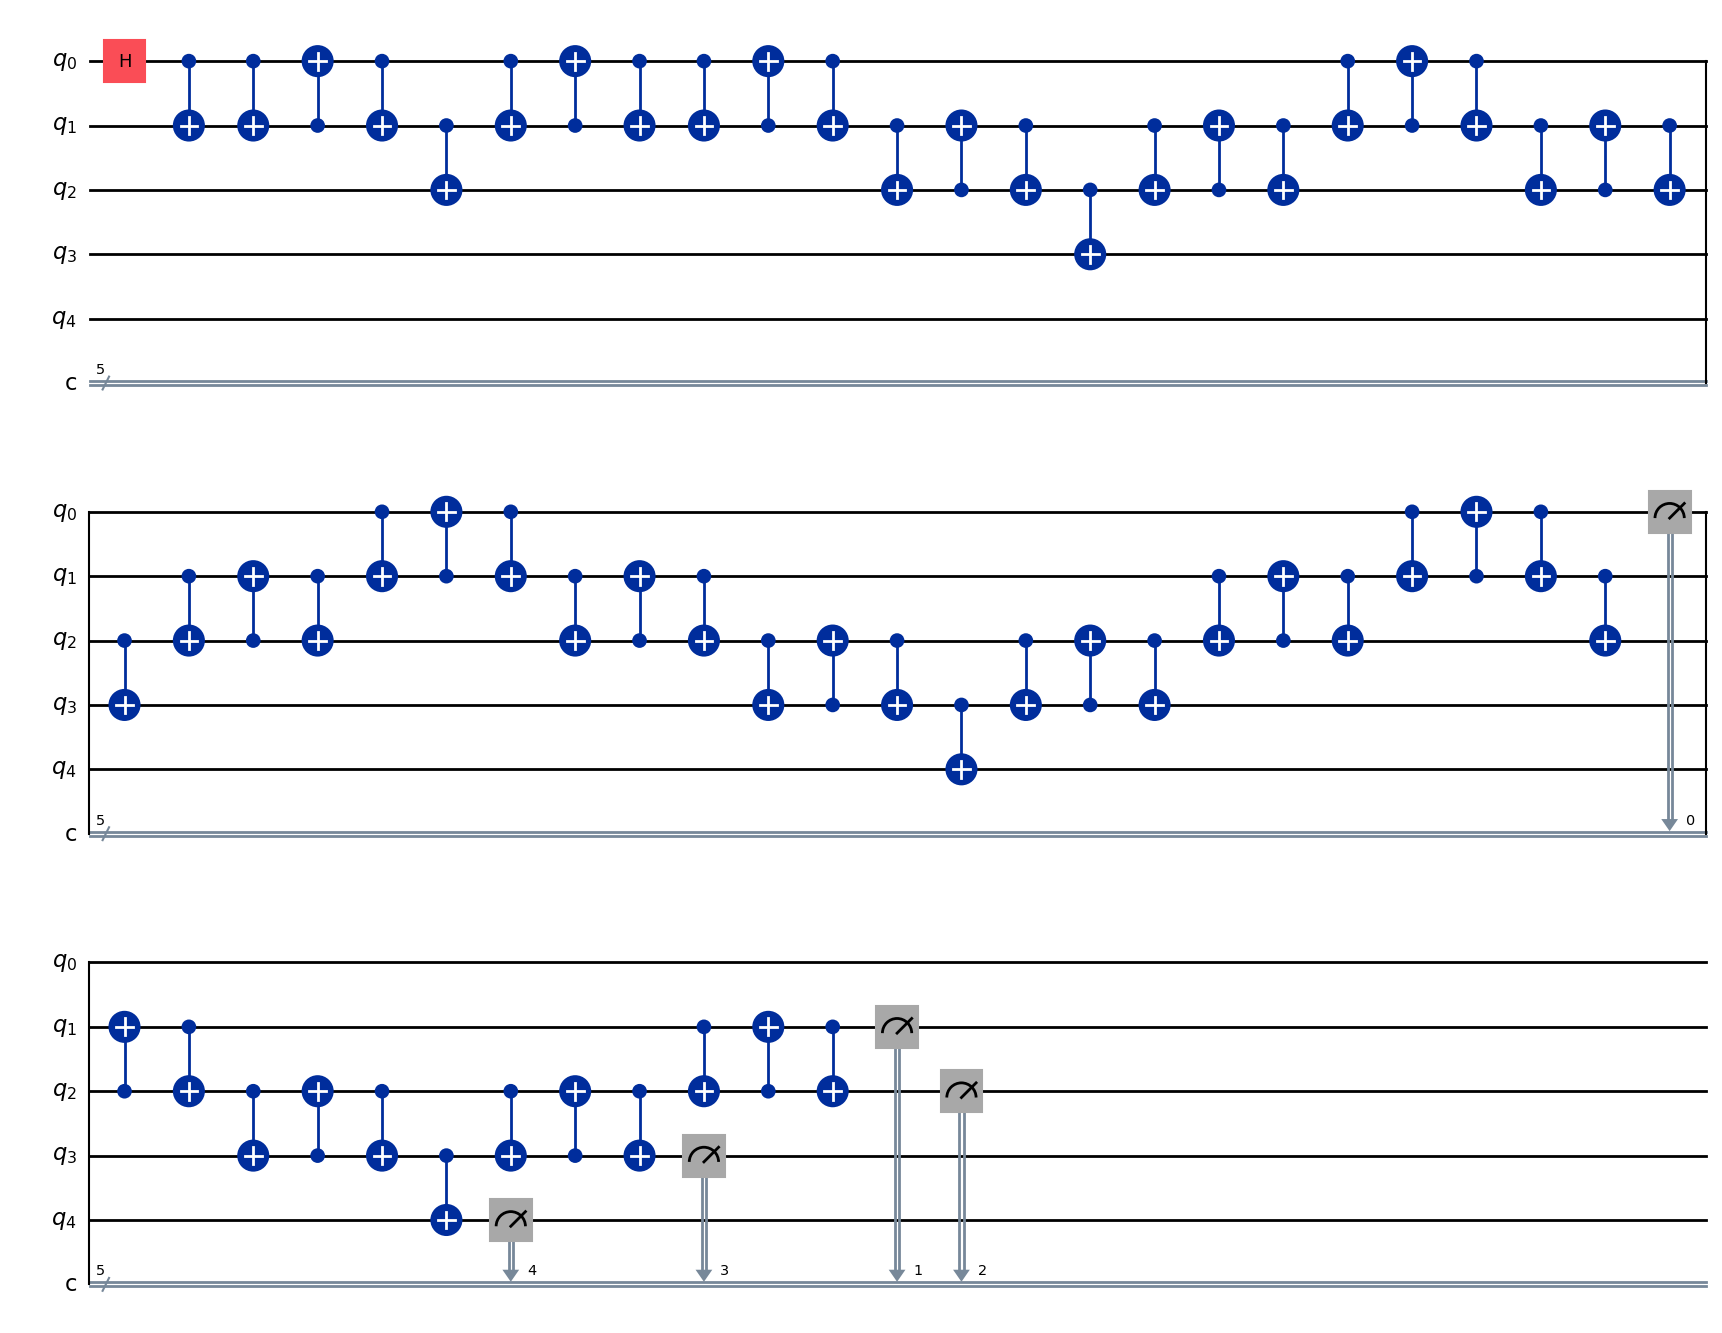

In [5]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

We used a vizualisation tool to represent this portion of the circuit. Only encoding our logical qubit, we use 64 `CX` gates, and performing the rest of the QEC algorithm will only add to this length. 

## Step 2: The neutral atom advantage

Now, with the capability to physically move our qubits around, we can apply `CX` gates between any two qubits in our circuit.
This allows the QEC algorithm to become much simpler.

In [6]:
@qasm2.extended
def create_bit_flip_circuit():
    q = qasm2.qreg(5)
    c = qasm2.creg(5)
    # Prepare initial state with Hadamard
    qasm2.h(q[0])
    # Encode into three-qubit state
    qasm2.cx(q[0], q[1])  # CNOT from qubit 0 to 1
    qasm2.cx(q[0], q[2])  # CNOT from qubit 0 to 2
    # Simulate bit-flip error on second qubit
    qasm2.x(q[1])
    # Add syndrome qubits and measure
    qasm2.cx(q[0], q[3])  # First syndrome
    qasm2.cx(q[1], q[3])
    qasm2.cx(q[0], q[4])  # Second syndrome
    qasm2.cx(q[2], q[4])
    # Measure syndrome qubits
    qasm2.measure(q[0], c[0])  # First syndrome measurement
    qasm2.measure(q[1], c[1])  # Second syndrome measurement
    # Measure all qubits
    qasm2.measure(q[2], c[2])
    qasm2.measure(q[3], c[3])
    qasm2.measure(q[4], c[4])

    return c

In [9]:
target = QASM2()
ast = target.emit(create_bit_flip_circuit)
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
h q[0];
CX q[0], q[1];
CX q[0], q[2];
x q[1];
CX q[0], q[3];
CX q[1], q[3];
CX q[0], q[4];
CX q[2], q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];


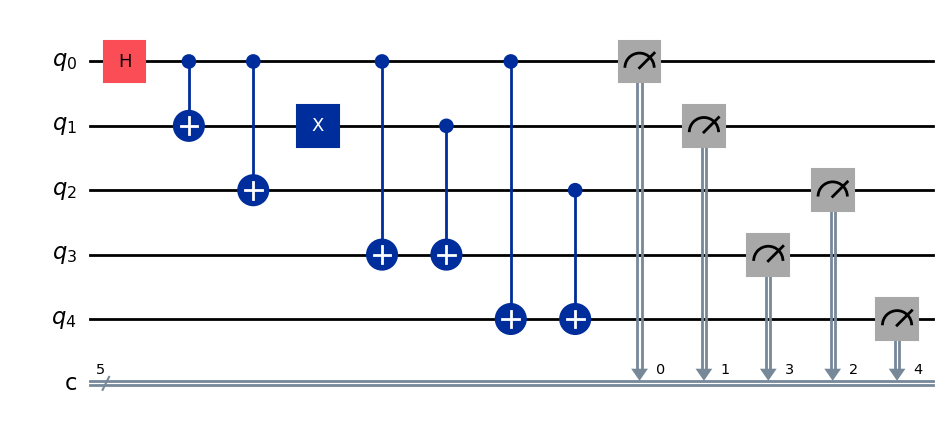

In [10]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

### **With this architecture, we only use 10% of the two-qubit gate count.**

## Step 3: Comparing the running time of both architectures

Here, we use a noiseless model to compare our two approaches, the nearest-neighbor and neutral-atom architectures.

In [7]:
def runtime_comparison(shots_max: int, shots_step: int):
    import time
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    
    # Initialize lists to store timing data
    standard_times = []
    cn_times = []
    shot_counts = []
    
    # Run experiments for different shot counts
    for shots in range(100, shots_max, shots_step):
        # Time standard circuit
        start_time = time.time()
        results = device.multi_run(create_bit_flip_circuit, _shots=shots)
        execution_time = time.time() - start_time
        standard_times.append(execution_time)
        
        # Time CN circuit
        start_time = time.time()
        results_CN = device.multi_run(create_bit_flip_circuit_CN, _shots=shots)
        execution_time_CN = time.time() - start_time
        cn_times.append(execution_time_CN)
        
        shot_counts.append(shots)
        
        # Print timing results
        # print(f"\nStandard circuit with {shots} shots: {execution_time:.4f} seconds")
        # print(f"Closest Neighbor circuit with {shots} shots: {execution_time_CN:.4f} seconds")
        
        # # Get measurement counts
        # counts = to_bitstrings(results)
        # counts_CN = to_bitstrings(results_CN)
        
        
        # # Print measurement results
        # print("\nMeasurement results for standard circuit:")
        # for key, value in counts.items():
        #     print(f"{key}: {value}")
        # print("\nMeasurement results for CN circuit:")
        # for key, value in counts_CN.items():
        #     print(f"{key}: {value}")
        print("\nShot count:")
        print(shots)
# Create plot
    plt.figure(figsize=(12, 8))
    plt.plot(shot_counts, standard_times, 'bo-', label='Neutral Atom based Circuit', 
            markersize=8, linewidth=2)
    plt.plot(shot_counts, cn_times, 'ro-', label='Super conducting Qbit circuit',
            markersize=8, linewidth=2)
    
    # LaTeX formatting for labels
    plt.xlabel(r'Number of Shots ($N$)', fontsize=14)
    plt.ylabel(r'Execution Time (seconds)', fontsize=14)
    plt.title(r'Runtime Comparison of Different Quantum Circuits Architecture', fontsize=16)
    
    # Customize plot appearance
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, framealpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add minor ticks
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Shot count:
100

Shot count:
600

Shot count:
1100

Shot count:
1600

Shot count:
2100

Shot count:
2600

Shot count:
3100

Shot count:
3600

Shot count:
4100

Shot count:
4600


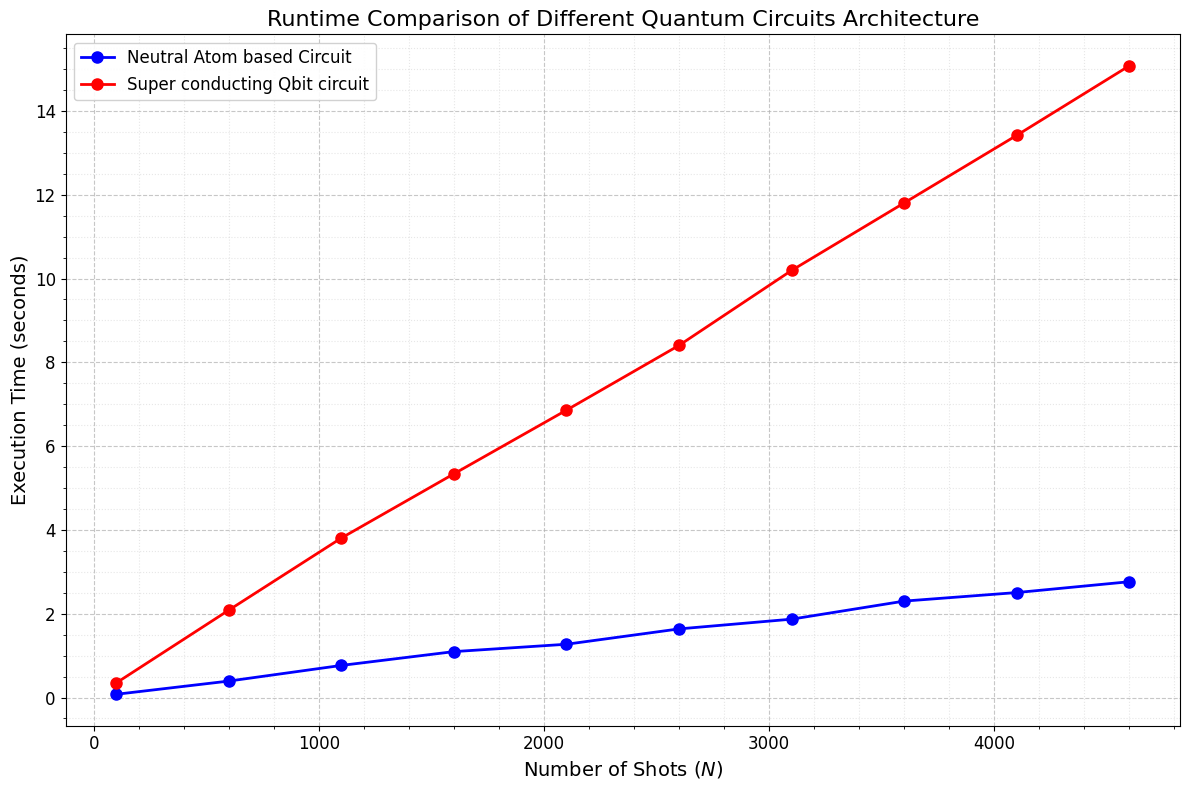

In [8]:
time = runtime_comparison(5000, 500)

## Step 4: Adding noise to the circuit

Now, we'll introduce a noise model to put errors in the circuit.

In [11]:
@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        # apply the original run_pass to the lowered kernel
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer)
        # decompose all gates in the circuit to neutral atom gate set
        native_rewrite.rewrite(kernel.code)

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

In [16]:
def to_bitstrings(results):
    return Counter(map(lambda result:"".join(map(str, result)), results))

In [17]:
# add noise
noise_kernel = create_bit_flip_circuit.similar()
extended_opt.run_pass(noise_kernel, parallelize=True)
NoisePass(extended_opt)(noise_kernel)

noise_kernel = noise_kernel.similar(extended_opt.add(native))
device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
results = device.multi_run(noise_kernel, _shots=(800))

counts = to_bitstrings(results)

# Calculate total shots
total_shots = sum(counts.values())

# Initialize target states
Error_corrected_code = ['00000', '11100', '00101', '11001', '01010', '10110', '01111', '10011']

print("\nProbabilities:")
print("-" * 40)
print("Error corrected states:")
corrected_prob = 0
for state in Error_corrected_code:
    prob = counts.get(state, 0) / total_shots
    corrected_prob += prob
    print(f"{state}: {prob:.3f}")
print(f"Total probability of corrected states: {corrected_prob:.3f}")

print("\nStates were error where not corrected:")
other_prob = sum(counts.get(state, 0) for state in counts if state not in Error_corrected_code) / total_shots
print(f"Combined probability: {other_prob:.3f}")

# Print individual other states if they occurred
for state, count in counts.items():
    if state not in Error_corrected_code:
        prob = count / total_shots
        print(f"{state}: {prob:.3f}")

/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-pa


Probabilities:
----------------------------------------
Error corrected states:
00000: 0.013
11100: 0.007
00101: 0.001
11001: 0.005
01010: 0.460
10110: 0.464
01111: 0.005
10011: 0.001
Total probability of corrected states: 0.956

States were error where not corrected:
Combined probability: 0.044
10100: 0.007
10111: 0.013
01000: 0.010
00111: 0.003
11010: 0.005
11011: 0.001
01011: 0.003
11110: 0.003


These states usually correspond to what we expect from this portion of the error-correction code. The few cases which don't align are cases in which the noise affects our ancilla qubits used for the algorithm. In real hardware, this will be much less likely to occur --- the algorithm corrects errors in the three qubits that make up our logical qubit, but the two additional ancilla qubits only exist for a short legnth of time.
The ancilla qubits are measured quickly, with little time to decohere.

## Conclusion

We have demonstrated how the **bit flip code** can detect and correct a single bit-flip error. By encoding the logical qubit into three physical qubits, we can recover the original state even if one of the qubits experiences an `X` error. We have also shown how the Bloqade code and the capabilities of neutral-atom quantum computing can simplify the implementation of this QEC algorithm.
